In [1]:
import tensorflow.compat.v1 as tf1
# import tensorflow as tf2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf1.Session(config=config)

2024-11-15 12:23:58.170896: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 12:23:58.238432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 12:23:59.185585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-15 12:24:00.601238: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20169 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capab

In [44]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import backend as K  # 추가된 부분
from tensorflow.keras import layers  # Conv2D, MaxPooling2D 등 일부를 layers에서 가져올 수도 있습니다

def open_image(image_dir, image_file):
    """
    주어진 디렉터리와 파일명을 사용하여 이미지를 읽고, Grayscale 형식으로 변환합니다.
    
    매개변수:
    - image_dir (str): 이미지 파일이 저장된 디렉터리 경로.
    - image_file (str): 읽을 이미지 파일 이름.
    
    반환값:
    - Grayscale로 변환된 이미지 (numpy.ndarray).
    """
    image_path = os.path.join(image_dir, image_file)  # 디렉터리와 파일 이름을 결합하여 이미지 경로 생성
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)  # 이미지 읽고 Grayscale로 변환


def visualize_width_image(images):
    """
    여러 이미지를 가로로 출력합니다.
    
    매개변수:
    - images (list): 시각화할 이미지의 리스트.
    """
    plt.figure(figsize=(5 * len(images), 5))  # 이미지 갯수에 따라 가로 크기 조정
    for idx, image in enumerate(images):
        plt.subplot(1, len(images), idx + 1)  # 가로로 이미지를 나란히 출력
        plt.imshow(image, cmap='gray')  # Grayscale 형식으로 이미지 출력
        plt.axis('off')  # 축 비활성화
    plt.show()  # 시각화 출력


def visualize_hight_image(images):
    """
    여러 이미지를 세로로 출력합니다.
    
    매개변수:
    - images (list): 시각화할 이미지의 리스트.
    """
    plt.figure(figsize=(5, 5 * len(images)))  # 이미지 갯수에 따라 세로 크기 조정
    for idx, image in enumerate(images):
        plt.subplot(len(images), 1, idx + 1)  # 세로로 이미지를 나란히 출력
        plt.imshow(image, cmap='gray')  # Grayscale 형식으로 이미지 출력
        plt.axis('off')  # 축 비활성화
    plt.show()  # 시각화 출력


In [70]:
def plot_accuracy_loss(history):
    """
    훈련 및 검증 정확도와 손실을 시각화합니다.
    
    매개변수:
    - history: 정확도 및 손실 값을 포함하는 훈련 기록 객체.
    """
    plt.figure(figsize=(10, 4))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('에포크(Epoch)')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

def calculate_f1_score(model, x_val, y_val, batch_size=4):
    """
    F1 점수를 계산하고 출력합니다.
    
    매개변수:
    - model: 검증 데이터 세트에서 예측을 생성할 훈련된 모델.
    - x_val: 검증 데이터 입력값.
    - y_val: 검증 데이터 레이블.
    - batch_size: 예측을 위한 배치 크기(기본값: 4).
    
    반환값:
    - y_pred: 예측된 레이블.
    - y_true: 실제 레이블.
    """
    y_pred = np.argmax(model.predict(x_val, batch_size=batch_size), axis=-1)
    y_true = np.argmax(y_val, axis=-1)

    f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='weighted')
    print(f"F1 점수: {f1:.2f}")

    return y_true, y_pred

def plot_confusion_matrix_with_metrics(y_true, y_pred):
    """
    혼동 행렬을 시각화하고 정밀도, 재현율, F1 점수를 출력합니다.
    
    매개변수:
    - y_true: 실제 레이블.
    - y_pred: 예측된 레이블.
    """
    # 혼동 행렬 계산
    print()
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten())
    
    # 메트릭 계산
    precision = precision_score(y_true.flatten(), y_pred.flatten(), average='weighted')
    recall = recall_score(y_true.flatten(), y_pred.flatten(), average='weighted')
    
    # 메트릭 출력
    print(f"정밀도(Precision): {precision:.2f}")
    print(f"재현율(Recall): {recall:.2f}")
    
    # 혼동 행렬 시각화
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('ConfusionMatrix')
    plt.show()
    
def plot_true_vs_pred_images(model, x_val, y_val, num_images=5, batch_size=4):
    """
    실제 이미지, 라벨 이미지 및 예측된 이미지를 나란히 시각화합니다.
    
    매개변수:
    - model: 검증 데이터 세트에서 예측을 생성할 훈련된 모델.
    - x_val: 검증 데이터 입력값.
    - y_val: 검증 데이터 레이블.
    - num_images: 시각화할 이미지 수 (기본값: 5).
    - batch_size: 예측을 위한 배치 크기(기본값: 4).
    """
    # 예측 생성
    y_pred = model.predict(x_val, batch_size=batch_size)
    
    plt.figure(figsize=(25, 3 * num_images))
    for i in range(num_images):
        # 실제 입력 이미지
        plt.subplot(num_images, 5, 5 * i + 1)
        plt.imshow(x_val[i].squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        # 실제 라벨 이미지 (첫 번째 채널 선택 - 전경)
        plt.subplot(num_images, 5, 5 * i + 2)
        plt.imshow(y_val[i][..., 1].squeeze(), cmap='gray')  # 전경 채널 시각화
        plt.title('Label Image (Foreground)')
        plt.axis('off')
        
        # 예측된 이미지 (전체 클래스 비교 - argmax로 클래스 라벨 선택)
        plt.subplot(num_images, 5, 5 * i + 3)
        plt.imshow(np.argmax(y_val[i], axis=-1).squeeze(), cmap='gray')
        plt.title('Original Label (Argmax)')
        plt.axis('off')
        
        # 예측된 이미지 (첫 번째 채널 선택 - 전경)
        plt.subplot(num_images, 5, 5 * i + 4)
        plt.imshow(y_pred[i][..., 1].squeeze(), cmap='gray')  # 전경 채널 시각화
        plt.title('Predicted Image (Foreground)')
        plt.axis('off')
        
        # 예측된 이미지 (전체 클래스 비교 - argmax로 클래스 라벨 선택)
        plt.subplot(num_images, 5, 5 * i + 5)
        plt.imshow(np.argmax(y_pred[i], axis=-1).squeeze(), cmap='gray')
        plt.title('Predicted Label (Argmax)')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
def main_display_result(history, model, x_val, y_val, batch_size=4, num_images=5):
    """
    전체 워크플로우 실행: 정확도/손실 그래프 시각화, F1 점수 계산, 혼동 행렬 및 메트릭 출력, 실제/예측 이미지 비교.
    
    매개변수:
    - history: 정확도 및 손실 값을 포함하는 훈련 기록 객체.
    - model: 검증 데이터 세트에서 예측을 생성할 훈련된 모델.
    - x_val: 검증 데이터 입력값.
    - y_val: 검증 데이터 레이블.
    - batch_size: 예측을 위한 배치 크기(기본값: 4).
    - num_images: 시각화할 이미지 수 (기본값: 5).
    """
    # 훈련 및 검증 정확도/손실 그래프 시각화
    plot_accuracy_loss(history)
    
    # F1 점수 계산 및 예측값 반환
    y_true, y_pred = calculate_f1_score(model, x_val, y_val, batch_size=batch_size)
    
    # 혼동 행렬 및 메트릭 출력
    plot_confusion_matrix_with_metrics(y_true, y_pred)
    
    # 실제 이미지와 예측된 이미지 비교 시각화
    plot_true_vs_pred_images(model, x_val, y_val, num_images=num_images, batch_size=batch_size)

In [3]:
def open_json(json_path):
    """
    JSON 데이터를 불러옵니다.
    
    매개변수:
    - json_path (str): JSON 파일의 경로.
    
    반환값:
    - json_data (dict): JSON 데이터로 파싱된 Python 딕셔너리 객체.
    """
    with open(json_path, "r") as f:
        json_data = json.load(f)  # JSON 파일 읽기 및 파싱
    
    return json_data


def get_polygon_from_json(json_data, image_filename):
    """
    JSON 데이터에서 특정 이미지에 대한 다각형(Polygon) 데이터를 추출합니다.
    
    매개변수:
    - json_data (dict): JSON에서 로드된 데이터.
    - image_filename (str): 다각형 정보를 추출할 이미지 파일 이름.
    
    반환값:
    - polygons (list): 다각형의 x, y 좌표 리스트 [(x_coords, y_coords), ...].
    """
    regions = json_data[image_filename]["regions"]  # 이미지와 관련된 영역 정보 가져오기
    polygons = []  # 다각형 정보를 저장할 리스트
    
    for region_id, region_info in regions.items():  # 영역 정보 순회
        shape_attributes = region_info["shape_attributes"]  # 모양 정보 추출
        if shape_attributes["name"] == "polygon":  # 다각형인지 확인
            x_coords = shape_attributes["all_points_x"]  # x 좌표
            y_coords = shape_attributes["all_points_y"]  # y 좌표
            polygons.append((x_coords, y_coords))  # 다각형 정보 추가
    
    return polygons


def creat_mask(image):
    """
    주어진 이미지 크기에 따라 빈 마스크 이미지를 생성합니다.
    
    매개변수:
    - image (numpy.ndarray): 원본 이미지.
    
    반환값:
    - image (numpy.ndarray): 동일한 크기의 빈 마스크 이미지 (값이 0으로 초기화된 배열).
    """
    image = np.zeros(image.shape)  # 이미지 크기와 동일한 배열 생성 (0으로 초기화)
    
    return image


def fill_polygons(image, polygons):
    """
    빈 마스크 이미지에 다각형 영역을 채웁니다.
    
    매개변수:
    - image (numpy.ndarray): 빈 마스크 이미지.
    - polygons (list): 다각형의 x, y 좌표 리스트 [(x_coords, y_coords), ...].
    
    반환값:
    - image (numpy.ndarray): 다각형이 채워진 마스크 이미지.
    """
    image = image.copy()  # 원본 이미지를 복사하여 수정
    for x_coords, y_coords in polygons:  # 다각형 리스트 순회
        pts = np.array([list(zip(x_coords, y_coords))], dtype=np.int32)  # 좌표를 다각형 형태로 변환
        cv2.fillPoly(image, pts, color=255)  # 다각형 내부를 흰색(255)으로 채움
    
    return image


def crate_mask_image(image_dir, json_path, image_file):
    """
    이미지와 JSON 데이터를 기반으로 다각형이 채워진 마스크 이미지를 생성합니다.
    
    매개변수:
    - image_dir (str): 원본 이미지 파일이 저장된 디렉터리 경로.
    - json_path (str): 다각형 정보를 포함하는 JSON 파일의 경로.
    - image_file (str): 처리할 이미지 파일 이름.
    
    반환값:
    - mask_image (numpy.ndarray): 생성된 마스크 이미지.
    """
    json_data = open_json(json_path)  # JSON 데이터 로드
    image = open_image(image_dir, image_file)  # 원본 이미지 로드
    
    mask_image = creat_mask(image)  # 빈 마스크 이미지 생성
                       
    return fill_polygons(mask_image, get_polygon_from_json(json_data, image_file))  # 다각형을 마스크에 채움

In [53]:
def image_resize(image, shape):
    """
    입력된 이미지의 크기를 지정된 shape로 조정합니다.
    
    매개변수:
    - image (numpy.ndarray): 크기 조정할 이미지.
    - shape (tuple): 조정할 크기 (높이, 너비).
    
    반환값:
    - resized_image (numpy.ndarray): 조정된 크기의 이미지.
    
    주의: 항상 채널 차원이 추가된 이미지를 반환합니다.
    """
    resized_image = cv2.resize(image, shape)  # 입력 이미지의 크기를 지정된 shape로 조정
    return resized_image


def expand_dims(image):
    """
    입력된 이미지를 채널 차원(axis=-1)까지 확장합니다.
    
    매개변수:
    - image (numpy.ndarray): 채널 차원을 확장할 이미지.
    
    반환값:
    - expanded_image (numpy.ndarray): 채널 차원이 추가된 이미지.
    """
    expanded_image = np.expand_dims(image, axis=-1)  # 이미지를 채널 차원까지 확장
    return expanded_image

def prepare_and_count_labels(y_train, y_val):
    """
    주어진 레이블 데이터(y_train, y_val)에 대해 0과 1로 이진화하고, 각 레이블의 빈도를 출력합니다.
    
    매개변수:
    - y_train (numpy.ndarray): 학습 데이터 레이블.
    - y_val (numpy.ndarray): 검증 데이터 레이블.
    
    반환값:
    - y_train.shape (tuple): 학습 레이블 크기.
    - y_val.shape (tuple): 검증 레이블 크기.
    """
    # 이진화: 0보다 큰 값을 1로, 0은 그대로 0으로 설정
    y_train = np.where(y_train > 0, 1, 0)
    y_val = np.where(y_val > 0, 1, 0)
    
    # y_train의 값별 빈도 계산
    unique, counts = np.unique(y_train, return_counts=True)
    value_counts = dict(zip(unique, counts))
    
    # 빈도 출력
    print("학습 데이터셋 레이블 빈도:")
    for value, count in value_counts.items():
        print(f"값: {value}, 빈도: {count}")
    
    # y_val의 값별 빈도 계산
    unique, counts = np.unique(y_val, return_counts=True)
    value_counts = dict(zip(unique, counts))
    
    # 빈도 출력
    print("검증 데이터셋 레이블 빈도:")
    for value, count in value_counts.items():
        print(f"값: {value}, 빈도: {count}")
    
    return y_train, y_val

def normalize_image(image):
    """
    이미지를 정규화하여 0에서 1 사이의 값으로 변환합니다.
    
    매개변수:
    - image (numpy.ndarray): 정규화할 이미지 배열.
    
    반환값:
    - normalized_image (numpy.ndarray): 정규화된 이미지 배열.
    """
    normalized_image = image.astype(np.float32) / 255.0
    return normalized_image

def add_background_channel(mask):
    """
    마스크에서 배경 채널을 추가합니다.
    
    매개변수:
    - mask (numpy.ndarray): 단일 채널 마스크 (0: 배경, 1: 객체).
    
    반환값:
    - multi_channel_mask (numpy.ndarray): 2채널 마스크 (채널 0: 배경, 채널 1: 객체).
    """
    background = 1 - mask  # 배경 채널은 객체 채널의 반전값
    multi_channel_mask = np.stack([background, mask], axis=-1)  # 채널 축으로 쌓음
    return multi_channel_mask

def prepare_dataset(image_dir, json_path, image_size=(512, 512), test_size=0.2, random_state=42):
    """
    주어진 이미지 디렉토리와 JSON 파일로부터 데이터를 준비하고 학습/검증 데이터셋을 반환합니다.
    데이터 내 0과 1 이외의 값이 포함된 경우 이진화 처리 및 빈도 계산을 수행합니다.

    매개변수:
    - image_dir (str): 이미지가 저장된 디렉토리 경로.
    - json_path (str): 폴리곤 마스크 정보가 포함된 JSON 파일 경로.
    - image_size (tuple): 이미지 크기 조정할 크기 (기본값: (512, 512)).
    - test_size (float): 테스트 데이터 비율 (기본값: 0.2).
    - random_state (int): 랜덤 상태 (기본값: 42).

    반환값:
    - x_train (numpy.ndarray): 학습 이미지.
    - x_val (numpy.ndarray): 검증 이미지.
    - y_train (numpy.ndarray): 학습 이미지 마스크 (2채널).
    - y_val (numpy.ndarray): 검증 이미지 마스크 (2채널).
    """
    image = []
    image_mask = []

    for image_file in os.listdir(image_dir):
        if image_file.endswith('.jpg'):  # 이미지 파일만 처리
            # 이미지와 마스크 데이터를 크기 조정 및 채널 차원 확장
            img = np.expand_dims(image_resize(open_image(image_dir, image_file), image_size), axis=-1)
            img = normalize_image(img)  # 이미지 정규화
            image.append(img)

            # 마스크 생성 및 크기 조정
            mask = image_resize(crate_mask_image(image_dir, json_path, image_file), image_size)
            mask = np.expand_dims(mask, axis=-1)  # 채널 차원 추가
            mask = np.squeeze(mask)  # 단일 채널 마스크
            mask = np.where(mask > 0, 1, 0)  # 이진화
            mask = add_background_channel(mask)  # 배경 채널 추가
            image_mask.append(mask)

    # NumPy 배열로 변환
    image = np.array(image)
    image_mask = np.array(image_mask)

    # 학습용과 검증용 데이터로 분할
    x_train, x_val, y_train, y_val = train_test_split(image, image_mask, test_size=test_size, random_state=random_state)

    # y_train과 y_val에서 0과 1 외의 값이 포함되어 있는지 확인
    unique_train = np.unique(y_train)
    unique_val = np.unique(y_val)

    if len(set(unique_train) - {0, 1}) > 0 or len(set(unique_val) - {0, 1}) > 0:
        print("경고: 레이블에 0과 1 이외의 값이 포함되어 있습니다. 레이블 준비를 수행합니다.")
        y_train, y_val = prepare_and_count_labels(y_train, y_val)
    else:
        print("레이블이 이미 이진화되어 있습니다 (0과 1만 포함).")

    # 크기 확인 및 불일치 시 처리
    x_train = np.squeeze(x_train)
    x_val = np.squeeze(x_val)
    y_train = np.squeeze(y_train)
    y_val = np.squeeze(y_val)

    # 크기 출력
    print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
    print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")

    return x_train, x_val, y_train, y_val

In [54]:
image_dir = 'FracAtlas/images/Fractured'
json_path = 'FracAtlas/Annotations/VGG JSON/VGG_fracture_masks.json'

x_train, x_val, y_train, y_val = prepare_dataset(image_dir, json_path, image_size=(512, 512), test_size=0.2, random_state=42)

레이블이 이미 이진화되어 있습니다 (0과 1만 포함).
x_train shape: (573, 512, 512), y_train shape: (573, 512, 512, 2)
x_val shape: (144, 512, 512), y_val shape: (144, 512, 512, 2)


In [58]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping

# U-Net 모델 정의
def unet_model(input_shape, num_classes=2):
    """
    U-Net 모델 정의 함수.
    
    매개변수:
    - input_shape: 입력 이미지 형태 (높이, 너비, 채널).
    - num_classes: 출력 채널 수. 기본값은 2 (배경과 객체).

    반환값:
    - Keras 모델 객체.
    """
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = concatenate([u2, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = concatenate([u1, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c5)  # num_classes에 따라 출력 채널 설정
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [59]:
# EarlyStopping 콜백 정의
def early_stopping_callback():
    """
    EarlyStopping 콜백을 정의하여 모델 학습 중 개선이 없을 때 학습을 중단하고
    가장 좋은 모델의 가중치를 복원합니다.

    - 'val_loss' 또는 'val_accuracy' 등을 모니터링하여 성능이 개선되지 않으면 학습을 중단
    - patience는 성능 개선이 없을 때 기다리는 에포크 수를 설정
    - restore_best_weights는 가장 좋은 모델의 가중치를 복원하는 기능을 활성화

    반환값:
    - early_stopping: EarlyStopping 콜백 객체
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',       # 모니터링할 값 ('val_loss' 또는 'val_accuracy' 등)
        patience=3,               # 개선이 없을 때 기다릴 에포크 수
        restore_best_weights=True # 가장 좋은 모델의 가중치를 복원
    )
    return early_stopping

# Jaccard Index (IoU) 계산 함수 정의
def iou(y_true, y_pred, smooth=1e-6):
    """
    Jaccard Index (IoU) 계산 함수
    IoU는 두 집합의 교집합 크기를 합집합 크기로 나눈 값을 측정하는 지표로,
    주로 세그멘테이션 모델의 성능을 평가할 때 사용됩니다.

    :param y_true: 실제 값 (ground truth), 모델이 예측해야 하는 대상의 실제 마스크
    :param y_pred: 예측 값 (predictions), 모델이 예측한 마스크
    :param smooth: 0으로 나누는 오류를 방지하기 위해 추가하는 작은 값 (기본값: 1e-6)
    :return: IoU (Intersection over Union), 예측과 실제 값 사이의 Jaccard 지표
    """
     # y_pred에서 softmax를 통해 확률로 출력된 두 채널 중 최대값을 선택
    y_pred = K.argmax(y_pred, axis=-1)  # 채널 차원에서 가장 높은 확률의 인덱스 선택
    y_true = K.argmax(y_true, axis=-1)  # y_true도 동일하게 전경 클래스 선택

    # float32로 변환
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    # Intersection 계산
    intersection = K.sum(K.abs(y_true * y_pred), axis=(1, 2))

    # Union 계산
    union = K.sum(y_true, axis=(1, 2)) + K.sum(y_pred, axis=(1, 2)) - intersection

    # IoU 계산
    iou_score = (intersection + smooth) / (union + smooth)

    return K.mean(iou_score)  # 배치에 대한 평균 IoU 반환

# 모델 컴파일 (Adam optimizer와 Jaccard Index를 사용)
def compile_model(model):
    """
    모델을 컴파일합니다. 주어진 모델에 Adam 옵티마이저, 
    sparse categorical crossentropy 손실 함수, 정확도 및 IoU 지표를 사용하여 컴파일합니다.

    매개변수:
    - model: 컴파일할 Keras 모델 객체

    반환값:
    - model: 컴파일된 Keras 모델 객체
    """
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', iou])
    return model


# 모델 학습 함수
def train_unet_model(x_train, y_train, x_val, y_val, batch_size=4, epochs=10, image_size=(512, 512)):
    """
    U-Net 모델을 학습하는 함수입니다. 주어진 학습 및 검증 데이터셋을 사용하여 U-Net 모델을 학습하고,
    EarlyStopping을 콜백으로 설정하여 학습을 최적화합니다.

    매개변수:
    - x_train (numpy.ndarray): 학습 이미지 데이터 (shape: (N, H, W, C))
    - y_train (numpy.ndarray): 학습 레이블 데이터 (shape: (N, H, W, 2))
    - x_val (numpy.ndarray): 검증 이미지 데이터 (shape: (N, H, W, C))
    - y_val (numpy.ndarray): 검증 레이블 데이터 (shape: (N, H, W, 2))
    - batch_size (int): 배치 크기 (기본값: 16)
    - epochs (int): 학습 에포크 수 (기본값: 10)
    - image_size (tuple): 입력 이미지의 크기 (기본값: (512, 512))

    반환값:
    - model: 학습된 U-Net 모델
    - history: 학습 과정에 대한 기록 (모델 학습 중의 손실 및 정확도 등)
    """
    # U-Net 모델 초기화 (입력 채널 1, 출력 채널 2)
    model = unet_model(input_shape=(image_size[0], image_size[1], 1))  # 입력은 grayscale 이미지

    # 모델 컴파일
    model = compile_model(model)

    # EarlyStopping 콜백 설정 (모델 학습 도중 성능 개선이 없으면 학습을 중단)
    early_stopping = early_stopping_callback()

    # 모델 학습 시작
    history = model.fit(
        x_train, y_train,               # 학습 데이터와 레이블
        validation_data=(x_val, y_val), # 검증 데이터와 레이블
        batch_size=batch_size,          # 배치 크기
        epochs=epochs,                  # 학습 에포크 수
        callbacks=[early_stopping]      # EarlyStopping 콜백
    )

    return model, history

In [60]:
# 모델 학습
model, history = train_unet_model(x_train, y_train, x_val, y_val, batch_size=2, epochs=10)

Epoch 1/10
287/287 [==============================] - 17s 48ms/step - loss: 0.0406 - accuracy: 0.9926 - iou: 9.2369e-06 - val_loss: 0.0260 - val_accuracy: 0.9948 - val_iou: 1.2306e-09
Epoch 2/10
287/287 [==============================] - 12s 40ms/step - loss: 0.0283 - accuracy: 0.9946 - iou: 1.1936e-09 - val_loss: 0.0272 - val_accuracy: 0.9948 - val_iou: 1.2306e-09
Epoch 3/10
287/287 [==============================] - 11s 39ms/step - loss: 0.0283 - accuracy: 0.9946 - iou: 1.1932e-09 - val_loss: 0.0291 - val_accuracy: 0.9948 - val_iou: 1.2306e-09
Epoch 4/10
287/287 [==============================] - 11s 39ms/step - loss: 0.0281 - accuracy: 0.9946 - iou: 1.1948e-09 - val_loss: 0.0279 - val_accuracy: 0.9948 - val_iou: 1.2306e-09


/tmp/ipykernel_4151374/4266053671.py:28: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4151374/4266053671.py:28: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4151374/4266053671.py:28: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


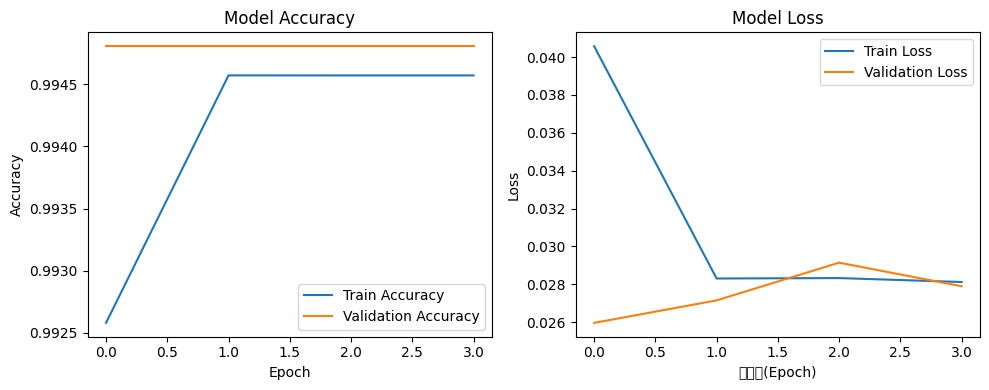

29/29 [==============================] - 1s 24ms/step
F1 점수: 0.99



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


정밀도(Precision): 0.99
재현율(Recall): 0.99


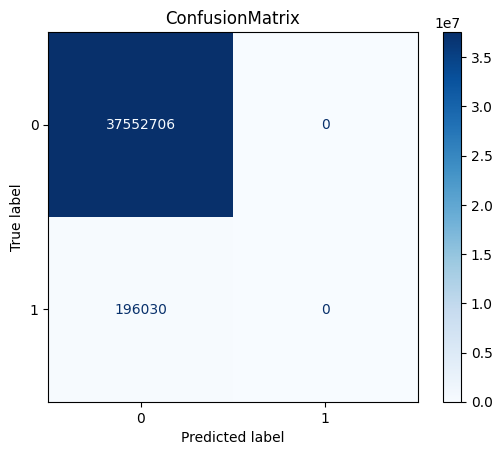

29/29 [==============================] - 1s 24ms/step


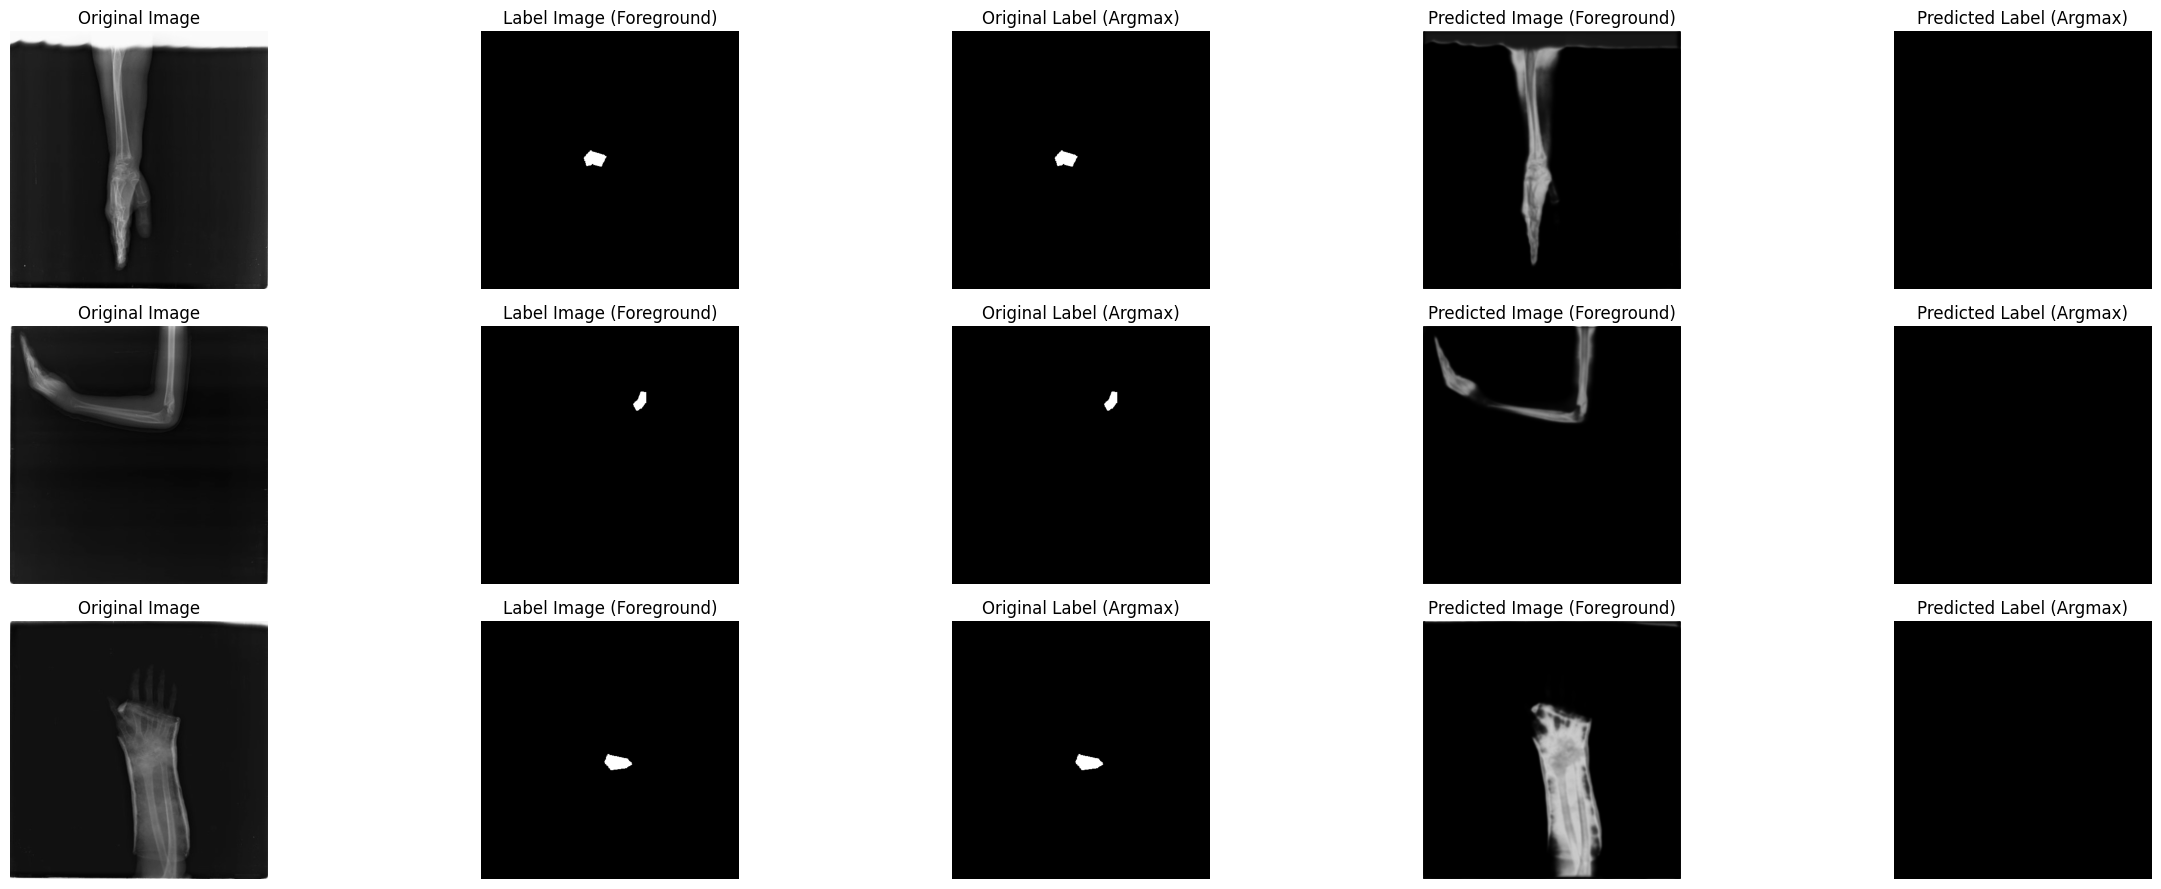

In [71]:
main_display_result(history=history, model=model, x_val=x_val, y_val=y_val, batch_size=5, num_images=3)

In [73]:
import tensorflow as tf
tf.keras.backend.clear_session()